**MACHINE LEARNING**

**HRV for detecting arousal**

In [56]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr

In [57]:
# Loading the dataset
file = r"C:\Users\Salin\OneDrive\Documentos\ESSEX\DSPROJECT\PPG_HR_Analysis_Longer_Intervals_\PPG\merged_features_norm_grey_new_arousal.csv"
df = pd.read_csv(file)

# Displaying info
df.head()
len(df)

2052

In [58]:
X = df.drop(columns=['Participant', 'Stimulus', 'Arousal'])
y = df['Arousal']
groups = df['Participant']

In [59]:
def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))

    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2 + 1e-8)
    return ccc


In [60]:
def evaluate_regression(true_values, predicted_values, results_df):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    corr, p = pearsonr(true_values, predicted_values)
    ccc = concordance_correlation_coefficient(np.array(true_values), np.array(predicted_values))
    rmse_std = results_df['RMSE'].std()
    mae_std = results_df['MAE'].std() 
    r2_std = results_df['R2'].std() 

    # Output
    print(f"RMSE: {rmse:.3f} ± {rmse_std:.3f}")
    print(f"MAE: {mae:.3f}" + (f" ± {mae_std:.3f}"))
    print(f"R² Score: {r2:.3f}" + (f" ± {r2_std:.3f}"))
    print(f"Correlation: {corr:.4f}")
    print(f"P-value: {p:.4e}")
    print(f"Concordance Correlation Coefficient (CCC): {ccc:.4f}")


**XGBOOST REGRESSOR**

In [61]:
logo = LeaveOneGroupOut()

In [62]:
true_values = []
predicted_values = []
results = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })


results_df = pd.DataFrame(results)

print("LOPO without hyperparameter tuning:")
evaluate_regression(true_values, predicted_values, results_df)


LOPO without hyperparameter tuning:
RMSE: 0.168 ± 0.034
MAE: 0.132 ± 0.031
R² Score: 0.227 ± 0.199
Correlation: 0.5124
P-value: 9.1424e-138
Concordance Correlation Coefficient (CCC): 0.4814


In [63]:
global_corr = X.corrwith(y)
global_corr = global_corr.sort_values(key=abs, ascending=False)
global_corr.head(10)

F1_CrossingPoints   -0.351969
pVLF                -0.151748
aVLF                -0.109718
pLF                  0.100511
F3_MaxArea          -0.086162
nLF                  0.071986
F9_KurtX            -0.060054
aTotal              -0.053120
nHF                 -0.046888
NN50                -0.045010
dtype: float64

In [64]:
# Checking number of missing values per column
missing_counts = X.isna().sum()

# Displaying only columns that have missing values
missing_counts[missing_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [65]:
X_mi = X.copy()

# Filling NaNs with column means 
X_mi = X_mi.fillna(X_mi.mean())

<Axes: title={'center': 'Mutual Information Scores'}>

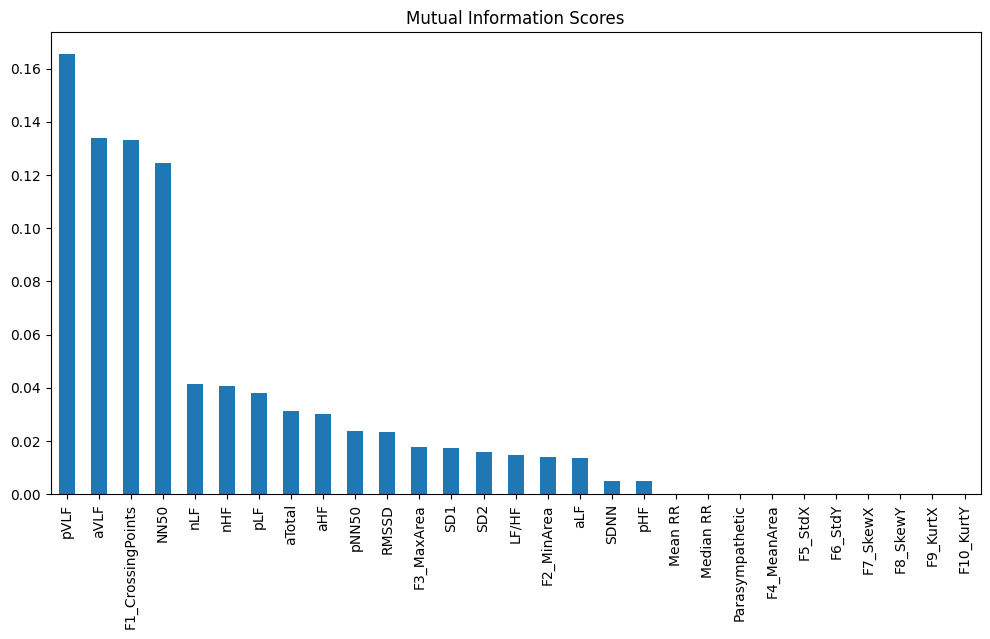

In [66]:
# MI between each feature and arousal
mi_scores = mutual_info_regression(X_mi, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Mutual Information Scores')

In [67]:
mi_series.sort_values(ascending=False).head(20)

pVLF                 0.165426
aVLF                 0.133885
F1_CrossingPoints    0.133037
NN50                 0.124604
nLF                  0.041493
nHF                  0.040712
pLF                  0.037955
aTotal               0.031338
aHF                  0.030152
pNN50                0.023663
RMSSD                0.023284
F3_MaxArea           0.017775
SD1                  0.017523
SD2                  0.015862
LF/HF                0.014821
F2_MinArea           0.014177
aLF                  0.013822
SDNN                 0.004924
pHF                  0.004887
Mean RR              0.000000
dtype: float64

In [68]:
selected_features = selected_features = mi_series[mi_series > 0.02].index.tolist()
X = df[selected_features]
X.head()

,RMSSD,NN50,pNN50,aVLF,aHF,aTotal,pVLF,pLF,nLF,nHF,F1_CrossingPoints
0,0.352012,-0.471698,0.199388,-1.000000,1.194322,0.949087,-1.000000,-0.616404,-0.617551,0.122455,-0.538462
1,0.700875,-0.528302,0.278150,-1.000000,0.537748,0.463529,-1.000000,-0.237624,-0.239903,0.047571,-0.532967
2,0.587072,-0.811321,0.219158,-1.000000,2.454736,1.874433,-1.000000,-1.000000,-1.000000,0.198291,-0.802198
3,0.246371,-0.169811,0.162264,8.750069,-0.468002,-0.413262,15.617413,0.187468,0.245816,-0.048743,-0.049451
4,0.242915,-0.547170,-0.024673,-1.000000,0.637673,0.515692,-1.000000,-0.387740,-0.389570,0.077248,-0.560440


In [69]:
filtered_df = df.dropna(subset=selected_features + ['Arousal'])  # Keeping only valid raws
print(f"Total raws after deleting the Nans:", len(filtered_df))

Total raws after deleting the Nans: 2052


In [70]:
X = filtered_df[selected_features]
y = filtered_df['Arousal']
groups = filtered_df['Participant']

In [71]:
true_values = []
predicted_values = []
results = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })


results_df = pd.DataFrame(results)
print("LOPO without hyperparameter tuning with most significant features:")
evaluate_regression(true_values, predicted_values, results_df)

LOPO without hyperparameter tuning with most significant features:
RMSE: 0.169 ± 0.032
MAE: 0.132 ± 0.028
R² Score: 0.218 ± 0.207
Correlation: 0.5145
P-value: 4.7390e-139
Concordance Correlation Coefficient (CCC): 0.4896


In [72]:
true_values = []
predicted_values = []
results = [] 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(XGBRegressor(random_state=42), param_grid,
                        cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    # Saving Parameters 
    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        **grid.best_params_
    })

results_df = pd.DataFrame(results)
print("Nested LOPO with hyperparameter tuning:")
evaluate_regression(true_values, predicted_values, results_df)
# For further analysis of the best params
params_df = results_df.drop(columns=['Participant', 'RMSE'])

Nested LOPO with hyperparameter tuning:
RMSE: 0.154 ± 0.034
MAE: 0.128 ± 0.033
R² Score: 0.350 ± 0.092
Correlation: 0.5975
P-value: 7.2221e-199
Concordance Correlation Coefficient (CCC): 0.4851


Best Parameters per Participant

To understand whether certain model configurations generalize better, the best hyperparameters selected during each LOPO iteration were tracked.

Below:
- The most commonly selected configuration.
- The configuration that resulted in the lowest average RMSE across participants.


In [73]:
# The most used configuration
most_common_configs = (
    params_df.value_counts()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
    .head(3)
)
print("Most Common Configurations:")
display(most_common_configs)

# The best config for better results
best_avg_configs = (
    results_df
    .groupby(['n_estimators', 'max_depth', 'learning_rate', 'subsample'])['RMSE']
    .mean()
    .reset_index()
    .sort_values(by='RMSE')
    .head(3)
)
print("Best Performing Configurations (Lowest Avg. RMSE):")
display(best_avg_configs)


Most Common Configurations:


,MAE,R2,learning_rate,max_depth,n_estimators,subsample,Count
0,0.064744,0.283422,0.01,3,200,0.8,1
1,0.071221,0.399630,0.01,3,200,1.0,1
2,0.072673,0.393529,0.01,3,200,0.8,1


Best Performing Configurations (Lowest Avg. RMSE):


,n_estimators,max_depth,learning_rate,subsample,RMSE
1,200,3,0.01,1.0,0.149731
0,200,3,0.01,0.8,0.150436
2,200,5,0.01,0.8,0.153039


**Random Forest Regressor**

In [74]:
true_values = []
predicted_values = []
results_df = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })


results_df = pd.DataFrame(results)
evaluate_regression(true_values, predicted_values, results_df)    

RMSE: 0.156 ± 0.033
MAE: 0.125 ± 0.033
R² Score: 0.340 ± 0.115
Correlation: 0.5839
P-value: 7.5337e-188
Concordance Correlation Coefficient (CCC): 0.5197


In [75]:
true_values = []
predicted_values = []
best_params_list = []
results = []

# Hyperparameters tunning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)
    best_params_list.append(grid.best_params_)

    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        **grid.best_params_
    })


results_df = pd.DataFrame(results)
evaluate_regression(true_values, predicted_values, results_df)


RMSE: 0.154 ± 0.032
MAE: 0.122 ± 0.033
R² Score: 0.357 ± 0.125
Correlation: 0.5975
P-value: 7.9171e-199
Concordance Correlation Coefficient (CCC): 0.5334


In [76]:
best_params_df = pd.DataFrame(best_params_list)
print("\nBest hyperparameters per participant:")
display(best_params_df.value_counts().head())


Best hyperparameters per participant:


max_depth  min_samples_leaf  min_samples_split  n_estimators
10         2                 2                  200             22
                             5                  200             21
                             2                  100              7
           1                 2                  200              3
           2                 5                  100              1
Name: count, dtype: int64

Support Vector Regressor

In [77]:
true_values = []
predicted_values = []
results = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    model = make_pipeline(
        StandardScaler(),
        SVR(kernel='rbf', C=1.0, gamma='scale')
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

results_df = pd.DataFrame(results)
print("SVR (rbf) with LOPO Results:")
evaluate_regression(true_values, predicted_values, results_df)


SVR (rbf) with LOPO Results:
RMSE: 0.170 ± 0.039
MAE: 0.139 ± 0.037
R² Score: 0.207 ± 0.162
Correlation: 0.4602
P-value: 4.5220e-108
Concordance Correlation Coefficient (CCC): 0.3808


In [78]:
true_values = []
predicted_values = []
results = []

param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 0.01, 0.001],
    'svr__kernel': ['rbf']
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    pipeline = make_pipeline(StandardScaler(), SVR())

    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV 
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        **grid.best_params_
        
    })

results_df = pd.DataFrame(results)
print("SVR (rbf) + Hyperparameter Tuning (LOPO):")
evaluate_regression(true_values, predicted_values, results_df)

results_df = pd.DataFrame(results)
params_df = results_df.drop(columns=['Participant', 'RMSE'])


SVR (rbf) + Hyperparameter Tuning (LOPO):
RMSE: 0.170 ± 0.038
MAE: 0.139 ± 0.036
R² Score: 0.209 ± 0.155
Correlation: 0.4619
P-value: 5.4016e-109
Concordance Correlation Coefficient (CCC): 0.3814
